<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_7_Self_attention_StarGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title IMPORTS 
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.nn import init
import functools
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

In [39]:
#@title HYPERPARAMETERS 
dataset_name = "img_align_celeba" #@param ["img_align_celeba"]
selected_attr_1 = "Blond_Hair" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Hair","Male","No_Beard","Sideburns","Smiling","Young"]
selected_attr_2 = "Black_Hair" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Eyeglasses","Goatee","Gray_Had_Hair","Male","No_Beard","Sideburns","Smiling","Young"]
selected_attr_3 = "Brown_Hair" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Hair","Male","No_Beard","Sideburns","Smiling","Young"]
selected_attr_4 = "Male" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Hair","Male","No_Beard","Sideburns","Smiling","Young"]
selected_attr_5 = "Young" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Hair","Male","No_Beard","Sideburns","Smiling","Young"]

attributes = [selected_attr_1,selected_attr_2,selected_attr_3,selected_attr_4,selected_attr_5]
print(attributes)

class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

datasets = { "img_align_celeba" : { "url" : 'https://www.dropbox.com/s/5hznryk2m0qxs2m/img_align_celeba.zip?dl=1',
                          "annotations" : "https://www.dropbox.com/s/vsxuglogmz4ezcf/list_attr_celeba.txt?dl=1",
                          "train_mode" : "train",
                          "test_mode" : "test"}           
            }

hp = Hyperparameters(
    epoch=0,
    n_epochs=50,
    batch_size=16,    
    train_split=.2,
    dataset_name=dataset_name,
    dataset_url=datasets[dataset_name]["url"],
    dataset_annotations=datasets[dataset_name]["annotations"],
    dataset_train_mode=datasets[dataset_name]["train_mode"],
    dataset_test_mode=datasets[dataset_name]["test_mode"], 
    selected_attrs=attributes,
    lr=.0002, 
    lr_gamma=.99999,   
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=64,
    channels=3,
    latent_dim=8,
    n_critic=5,
    sample_interval=200, 
    residual_blocks=16,   
    lambda_cls = 1,
    lambda_rec = 10,
    lambda_gp = 10)

img_root_folder = 'images'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % hp.dataset_name 
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

['Blond_Hair', 'Black_Hair', 'Brown_Hair', 'Male', 'Young']
Image data folders constructed images/img_align_celeba


In [3]:
#@title DOWNLOAD IMAGES
if len(os.listdir(image_folder)) == 0:
    from io import BytesIO
    from urllib.request import urlopen
    from zipfile import ZipFile
    zipurl = hp.dataset_url
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:        
            zfile.extractall(img_root_folder)
            print(f"Downloaded & Extracted {zipurl}")

In [4]:
#@title DOWNLOAD ANNOTATIONS
!pip install wget
import wget
wget.download(hp.dataset_annotations,image_folder)

'images/img_align_celeba/list_attr_celeba (1).txt'

In [5]:
#@title IMAGE DOWNLOAD HELPERS AND FORATTERS
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class CelebADataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train", attributes=None, train_split=.9):
        self.transform = transforms.Compose(transforms_)
        self.selected_attrs = attributes
        self.label_path = glob.glob("%s/*.txt" % root)[0]
        self.annotations = self.get_annotations()
        self.files = sorted([f"{root}/{file}" for file in self.annotations])
        #self.files = sorted(glob.glob("%s/*.jpg" % root))        
        self.files = self.files[0:int(len(self.files)*train_split)] if mode == "train" else self.files[int(len(self.files)*(1.0-train_split)):]
        print(len(self.files))               

    def get_annotations(self):
        """Extracts annotations for CelebA"""
        annotations = {}
        lines = [line.rstrip() for line in open(self.label_path, "r")]
        self.label_names = lines[1].split()
        for _, line in enumerate(lines[2:]):
            filename, *values = line.split()
            labels = []
            for attr in self.selected_attrs:
                idx = self.label_names.index(attr)
                labels.append(1 * (values[idx] == "1"))                      
            annotations[filename] = labels
        return annotations

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]
        filename = filepath.split("/")[-1]
        img = self.transform(Image.open(filepath))
        label = self.annotations[filename]
        label = torch.FloatTensor(np.array(label))

        return img, label

    def __len__(self):
        return len(self.files)

In [6]:
#@title IMAGE VISUALIZER HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg
def visualise_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

In [7]:
#@title CONFIGURE DATALOADERS
# Configure dataloaders
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

train_transforms = [
    transforms.Resize(int(1.25 * hp.img_size), Image.BICUBIC),
    transforms.CenterCrop(hp.img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std,)
]

dataloader = DataLoader(
    CelebADataset(
        image_folder, transforms_=train_transforms,
        mode="train", 
        attributes=hp.selected_attrs, 
        train_split=hp.train_split
    ),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=hp.n_cpu,
)

val_transforms = [
    transforms.Resize(int(1.25 * hp.img_size), Image.BICUBIC),
    transforms.CenterCrop(hp.img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
]

val_dataloader = DataLoader(
    CelebADataset(
        image_folder, transforms_=val_transforms, mode="val", attributes=hp.selected_attrs
    ),
    batch_size=10,
    shuffle=True,
    num_workers=1,
)

40519
182340


[]


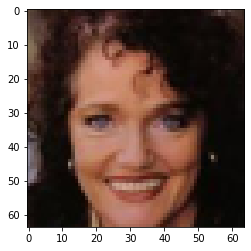

['Young']


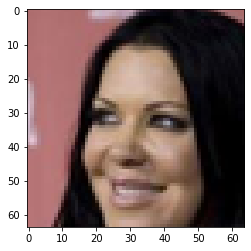

['Black_Hair', 'Young']


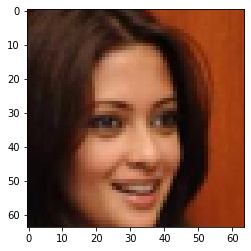

['Blond_Hair', 'Young']


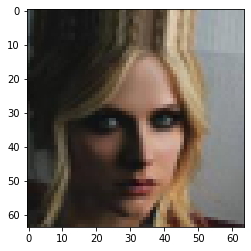

['Brown_Hair', 'Male', 'Young']


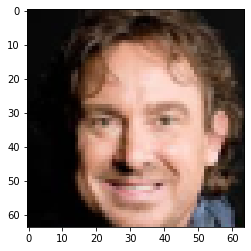

['Brown_Hair']


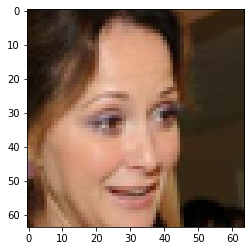

['Male']


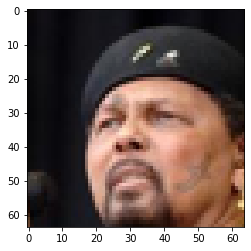

['Male']


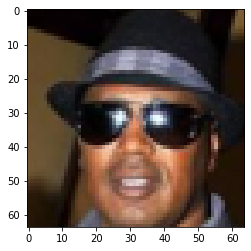

['Male']


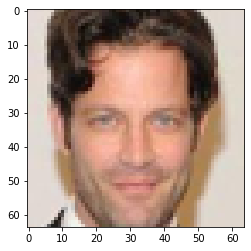

['Blond_Hair', 'Young']


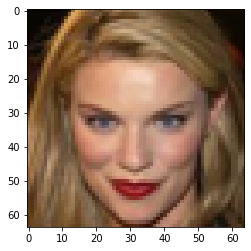

['Male']


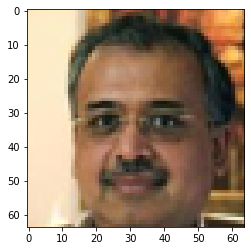

['Black_Hair', 'Young']


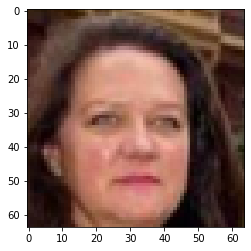

['Blond_Hair', 'Young']


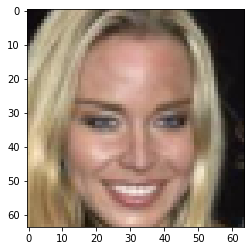

['Brown_Hair', 'Male', 'Young']


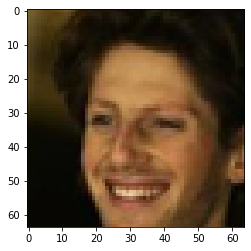

['Blond_Hair']


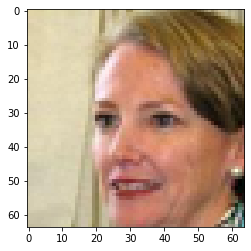

['Blond_Hair', 'Young']


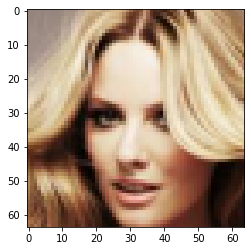

In [8]:
#@title VISUALING SAMPLE DATA { run: "auto" }
pic_size = 4 #@param {type:"integer"} {type:"slider", min:1, max:30, step:1}

dataiter = iter(dataloader)
(imgs, labels) = dataiter.next()

for i in range(hp.batch_size):
  print([hp.selected_attrs[i] for i,label in enumerate(labels[i]) if label > 0])
  imshow(make_grid(imgs[i]), size=pic_size)


In [9]:
#@title HELPER FUNCTION - COMPUTE GRADIENT PENALTY
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates, _ = D(interpolates)
    fake = Variable(Tensor(np.ones(d_interpolates.shape)), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [10]:
#@title SPECTRAL NORMALIZATION & SELF-ATTENTION
def init_linear(linear):
    init.xavier_uniform_(linear.weight)
    linear.bias.data.zero_()


def init_conv(conv, glu=True):
    init.xavier_uniform_(conv.weight)
    if conv.bias is not None:
        conv.bias.data.zero_()


class SpectralNorm:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        u = getattr(module, self.name + '_u')
        size = weight.size()
        weight_mat = weight.contiguous().view(size[0], -1)
        with torch.no_grad():
            v = weight_mat.t() @ u
            v = v / v.norm()
            u = weight_mat @ v
            u = u / u.norm()
        sigma = u @ weight_mat @ v
        weight_sn = weight / sigma
        # weight_sn = weight_sn.view(*size)

        return weight_sn, u

    @staticmethod
    def apply(module, name):
        fn = SpectralNorm(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', weight)
        input_size = weight.size(0)
        u = weight.new_empty(input_size).normal_()
        module.register_buffer(name, weight)
        module.register_buffer(name + '_u', u)

        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight_sn, u = self.compute_weight(module)
        setattr(module, self.name, weight_sn)
        setattr(module, self.name + '_u', u)


def spectral_norm(module, name='weight'):
    SpectralNorm.apply(module, name)

    return module


def spectral_init(module, gain=1):
    init.xavier_uniform_(module.weight, gain)
    if module.bias is not None:
        module.bias.data.zero_()

    return spectral_norm(module)


def leaky_relu(input):
    return F.leaky_relu(input, negative_slope=0.2)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, gain=2 ** 0.5):
        super().__init__()

        self.query = spectral_init(nn.Conv1d(in_channel, in_channel // 8, 1),
                                   gain=gain)
        self.key = spectral_init(nn.Conv1d(in_channel, in_channel // 8, 1),
                                 gain=gain)
        self.value = spectral_init(nn.Conv1d(in_channel, in_channel, 1),
                                   gain=gain)

        self.gamma = nn.Parameter(torch.tensor(0.0)) 

    def forward(self, input):
        shape = input.shape
        flatten = input.view(shape[0], shape[1], -1)
        query = self.query(flatten).permute(0, 2, 1)
        key = self.key(flatten)
        value = self.value(flatten)
        query_key = torch.bmm(query, key)
        attn = F.softmax(query_key, 1)
        attn = torch.bmm(value, attn)
        attn = attn.view(*shape)        
        out = (self.gamma * attn + input) 
        
        return out

In [11]:
#@title GENERATOR & DISCRIMINATOR
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)


##############################
#           RESNET
##############################
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [
            spectral_norm(nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False)),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            SelfAttention(in_features),
            spectral_norm(nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False)),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
        ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, img_shape=(3, 128, 128), res_blocks=9, c_dim=5):
        super(GeneratorResNet, self).__init__()
        channels, img_size, _ = img_shape

        # Initial convolution block
        model = [
            spectral_norm(nn.Conv2d(channels + c_dim, 64, 7, stride=1, padding=3, bias=False)),
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        curr_dim = 64
        for _ in range(2):
            model += [
                spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, stride=2, padding=1, bias=False)),
                nn.InstanceNorm2d(curr_dim * 2, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ]
            curr_dim *= 2

        # Residual blocks
        for _ in range(res_blocks):
            model += [ResidualBlock(curr_dim)]

        # Upsampling
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(curr_dim, curr_dim // 2, 4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(curr_dim // 2, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ]
            curr_dim = curr_dim // 2

        # Output layer
        model += [nn.Conv2d(curr_dim, channels, 7, stride=1, padding=3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat((x, c), 1)
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, img_shape=(3, 128, 128), c_dim=5, n_strided=6):
        super(Discriminator, self).__init__()
        channels, img_size, _ = img_shape

        def discriminator_block(in_filters, out_filters):
            """Returns downsampling layers of each discriminator block"""
            layers = [spectral_norm(nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)), nn.LeakyReLU(0.01)]
            return layers

        layers = discriminator_block(channels, 64)
        curr_dim = 64
        for _ in range(n_strided - 1):
            layers.extend(discriminator_block(curr_dim, curr_dim * 2))
            curr_dim *= 2

        self.model = nn.Sequential(*layers)

        # Output 1: PatchGAN
        self.out1 = spectral_norm(nn.Conv2d(curr_dim, 1, 3, padding=1, bias=False))
        # Output 2: Class prediction
        kernel_size = img_size // 2 ** n_strided
        self.out2 = spectral_norm(nn.Conv2d(curr_dim, c_dim, kernel_size, bias=False))

    def forward(self, img):
        feature_repr = self.model(img)
        out_adv = self.out1(feature_repr)
        out_cls = self.out2(feature_repr)
        return out_adv, out_cls.view(out_cls.size(0), -1)

In [12]:
#@title SETUP, LOSS and INITIALIZE MODELS 

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

input_shape = (hp.channels, hp.img_size, hp.img_size)
c_dim = len(hp.selected_attrs)

# Loss functions
criterion_cycle = torch.nn.L1Loss()


def criterion_cls(logit, target):
    return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)

# Initialize generator and discriminator
generator = GeneratorResNet(img_shape=input_shape, res_blocks=hp.residual_blocks, c_dim=c_dim)
discriminator = Discriminator(img_shape=input_shape, c_dim=c_dim)

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_cycle.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Using CUDA


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
  )
  (out1): Conv2d(2048, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (out2): Conv2d(2048, 5, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

In [13]:
#@title SAMPLING IMAGES
label_changes = [
    ((0, 1), (1, 0), (2, 0)),  # Set to black hair
    ((0, 0), (1, 1), (2, 0)),  # Set to blonde hair
    ((0, 0), (1, 0), (2, 1)),  # Set to brown hair
    ((3, -1),),  # Flip gender
    ((4, -1),),  # Age flip
]

def sample_images(batches_done):
    """Saves a generated sample of domain translations"""
    val_imgs, val_labels = next(iter(val_dataloader))
    val_imgs = Variable(val_imgs.type(Tensor))
    val_labels = Variable(val_labels.type(Tensor))
    img_samples = None
    for i in range(10):
        img, label = val_imgs[i], val_labels[i]
        # Repeat for number of label changes
        imgs = img.repeat(c_dim, 1, 1, 1)
        labels = label.repeat(c_dim, 1)
        # Make changes to labels
        for sample_i, changes in enumerate(label_changes):
            for col, val in changes:
                labels[sample_i, col] = 1 - labels[sample_i, col] if val == -1 else val

        # Generate translations
        gen_imgs = generator(imgs, labels)
        # Concatenate images by width
        gen_imgs = torch.cat([x for x in gen_imgs.data], -1)
        img_sample = torch.cat((img.data, gen_imgs), -1)
        # Add as row to generated samples
        img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)

    path = "images/%s.png" % batches_done
    save_image(img_samples.view(1, *img_samples.shape), path, normalize=True)
    return path
    

In [41]:
#@title OPTIMIZERS
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=hp.lr, betas=(hp.b1,hp.b2))

scheduler_G = StepLR(optimizer_G, step_size=1, gamma=hp.lr_gamma)
scheduler_D = StepLR(optimizer_D, step_size=1, gamma=hp.lr_gamma)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

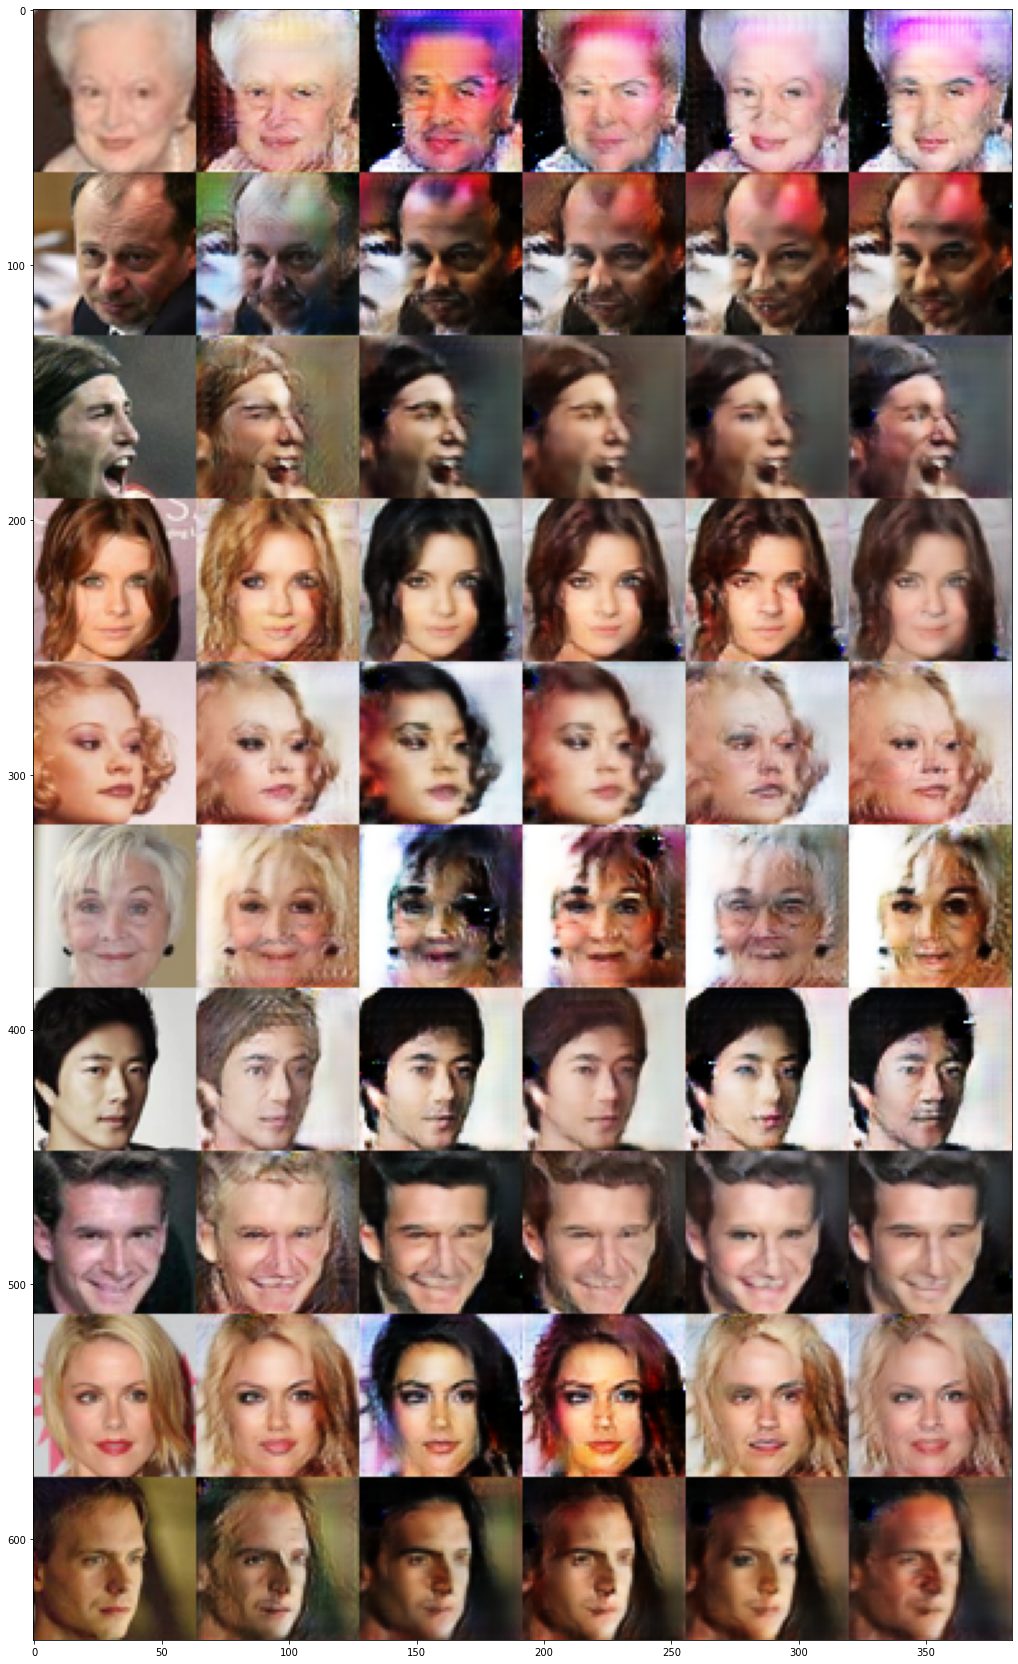

[Epoch 49/50] [Batch 2530/2533] [D adv: -3.963441, aux: 1.131831] [G loss: -14.128675, adv: -19.212374, aux: 3.415088, cycle: 0.166861] [Learing Rate: D: 0.000155, G: 0.000155}] ETA: 0:00:00.737469

In [42]:
#@title TRAINING
saved_samples = []
start_time = time.time()
batches_output=1
for epoch in range(hp.epoch, hp.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        # Model inputs
        imgs = Variable(imgs.type(Tensor))
        labels = Variable(labels.type(Tensor))

        # Sample labels as generator inputs
        sampled_c = Variable(Tensor(np.random.randint(0, 2, (imgs.size(0), c_dim))))
        # Generate fake batch of images
        fake_imgs = generator(imgs, sampled_c)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real images
        real_validity, pred_cls = discriminator(imgs)
        # Fake images
        fake_validity, _ = discriminator(fake_imgs.detach())
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, imgs.data, fake_imgs.data)
        # Adversarial loss
        loss_D_adv = -torch.mean(real_validity) + torch.mean(fake_validity) + hp.lambda_gp * gradient_penalty
        # Classification loss
        loss_D_cls = criterion_cls(pred_cls, labels)
        # Total loss
        loss_D = loss_D_adv + hp.lambda_cls * loss_D_cls

        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Every n_critic times update generator
        if i % hp.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Translate and reconstruct image
            gen_imgs = generator(imgs, sampled_c)
            recov_imgs = generator(gen_imgs, labels)
            # Discriminator evaluates translated image
            fake_validity, pred_cls = discriminator(gen_imgs)
            # Adversarial loss
            loss_G_adv = -torch.mean(fake_validity)
            # Classification loss
            loss_G_cls = criterion_cls(pred_cls, sampled_c)
            # Reconstruction loss
            loss_G_rec = criterion_cycle(recov_imgs, imgs)
            # Total loss
            loss_G = loss_G_adv + hp.lambda_cls * loss_G_cls + hp.lambda_rec * loss_G_rec

            loss_G.backward()
            optimizer_G.step()

            scheduler_G.step()
            scheduler_D.step()
            lr_D = scheduler_D.get_last_lr()[0]
            lr_G = scheduler_G.get_last_lr()[0]

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(dataloader) + i
            batches_left = hp.n_epochs * len(dataloader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - start_time) / (batches_done + 1))

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [D adv: %f, aux: %f] [G loss: %f, adv: %f, aux: %f, cycle: %f] [Learing Rate: D: %f, G: %f}] ETA: %s"
                % (
                    epoch,
                    hp.n_epochs,
                    i,
                    len(dataloader),
                    loss_D_adv.item(),
                    loss_D_cls.item(),
                    loss_G.item(),
                    loss_G_adv.item(),
                    loss_G_cls.item(),
                    loss_G_rec.item(),
                    lr_D,
                    lr_G,
                    time_left,
                )
            )

            # If at sample interval sample and save image
            if batches_done / hp.sample_interval > batches_output:
                batches_output=batches_output+1
                clear_output()
                visualise_output(sample_images(batches_done), 30,30)
        
        